# ERNIE

## Library

In [31]:
!pip install transformers==4.37.2

In [32]:
!pip install contractions

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import contractions
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve

from keras.preprocessing.sequence import pad_sequences

from imblearn.over_sampling import SMOTE

import transformers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from transformers import TFRobertaModel
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer, AutoConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, Precision
from sklearn.metrics import f1_score
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')
import torch
from huggingface_hub import HfFolder, notebook_login
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from transformers import AutoTokenizer, TFBertModel
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'gpu'

## Importing the Dataset

In [36]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


The dataset consists of 47,692 text. Most of the text are consistent for cyberbullying. There are 6 types of cyberbullying in this text, 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity', and the rest of it are not considered as cyberbullying ('not_cyberbullying'). For example 'The thing about Uber is, even if it wasn't a horrible, sexist, shitty company, I would still be against it.' is categorized as 'not_cyberbullying' because it is simply a harmless statement/opinion.

In [37]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (47692, 2)


In [38]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

There are 6 types of cyberbullying that are depicted in this data, 'not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity'.

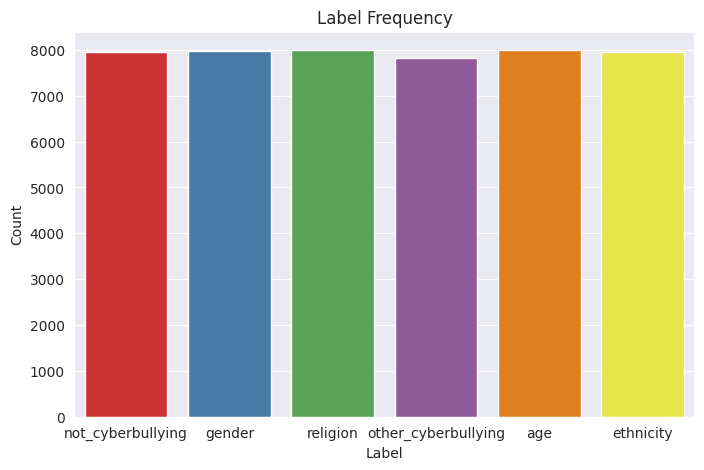

In [39]:
plt.figure(figsize=(8,5))
sns.countplot(x = 'cyberbullying_type', data = df, palette = 'Set1')
plt.title('Label Frequency')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

All the classes within this data are balanced

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


## Data Cleaning

In [41]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

There are no missing values in the data.

### Label Encoding for OneHotEncoding

Cyberbullying types have no ranking. Thus, we use OneHotEncoding to transform the 'cyberbullying_type' into a set of numbers. But, first we have to change the labels of 'cyberbullying_type' into numbers.

In [42]:
def modify_df(dataset):
    df = dataset.copy()

    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 0 if x == 'not_cyberbullying' else x)
    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 1 if x == 'gender' else x)
    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 2 if x == 'religion' else x)
    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 3 if x == 'other_cyberbullying' else x)
    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 4 if x == 'age' else x)
    df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 5 if x == 'ethnicity' else x)
    return df


def df_info(df,name):
    not_cyberbullying = df[df.cyberbullying_type == 0].shape[0]
    gender = df[df.cyberbullying_type == 1].shape[0]
    religion = df[df.cyberbullying_type == 2].shape[0]
    other_cyberbullying = df[df.cyberbullying_type == 3].shape[0]
    age = df[df.cyberbullying_type == 4].shape[0]
    eth = df[df.cyberbullying_type == 5].shape[0]

    print(f"\n{name} -----> shape : {df.shape}")
    print(f"{name} -----> not_cyberbullying: {not_cyberbullying}, gender: {gender}, religion: {religion}, other_cyberbullying: {other_cyberbullying}, age: {age}, ethnicity: {eth}\n")

    return None

In [43]:
df = modify_df(df)
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",5
47688,Turner did not withhold his disappointment. Tu...,5
47689,I swear to God. This dumb nigger bitch. I have...,5
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,5


## Data Preprocessing

In this step, we will tokenize the text with AutoTokenizer from Hugging Face Transformers library, lemmatize the text, and much more.

### Word Preprocessing

Word preprocessing in NLP is done to clean and transform raw text data into a format that is suitable for analysis or machine learning models. Word preprocessing involves several steps to enhance the quality of the textual data and improve the performance of NLP applications, such as lemmatization, stopword removal, and many more.

### Lemmatization, Stopword Removal, Regex Substitution, Contractions Fix, Lowercasing, and Joining Tokens

- **Stopword removal** removes common English stopwords using the NLTK library's stopwords.words('english'). Additionally, it excludes certain negative words from the stop words set to avoid changing the meaning of negated expressions.
- **Lemmatization** is the process of reducing words to their base or root form, considering their meaning in the context of the language. The base form of a word is known as its lemma. Lemmatization is often employed in NLP and text analysis to standardize words and reduce inflected words to a common base form. For example, the lemma of 'cooking' can be reduced to 'cook'.
- **Regex Substitution** uses regular expressions (re.sub) to replace characters that are not in the range of uppercase 'A' to lowercase 'z' with a space.
- **Contractions fix** fixes contractions using the `contractions.fix` function. Contractions are expanded to their full forms. For example,"can't" becomes "cannot".
- Lowercasing converts text to its lowercase
- Joining the preprocessed tokens back into a sentence.


In [44]:
def preprocess_sent(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

### Splitting the Data

In this section, we split the data to 70% training data, 15% validation data, 15% testing data. Then, we apply the function`preprocess_sent to each set (train, valid, test).

In [45]:
train, valid_test = train_test_split(df, test_size = 0.3, shuffle=True, random_state=42)
valid, test = train_test_split(valid_test, test_size = 0.5, shuffle=True, random_state=42)

train['tweet_text'] = train['tweet_text'].apply(lambda x: preprocess_sent(x))
valid['tweet_text'] = valid['tweet_text'].apply(lambda x: preprocess_sent(x))
test['tweet_text'] = test['tweet_text'].apply(lambda x: preprocess_sent(x))

df_info(train, "train")
df_info(valid, "valid")
df_info(test, "test")

x_train = train[["tweet_text"]]
y_train = train[["cyberbullying_type"]]

x_valid = valid[["tweet_text"]]
y_valid = valid[["cyberbullying_type"]]

x_test = test[["tweet_text"]]
y_test = test[["cyberbullying_type"]]


train -----> shape : (33384, 2)
train -----> not_cyberbullying: 5479, gender: 5630, religion: 5657, other_cyberbullying: 5432, age: 5643, ethnicity: 5543


valid -----> shape : (7154, 2)
valid -----> not_cyberbullying: 1223, gender: 1182, religion: 1175, other_cyberbullying: 1182, age: 1173, ethnicity: 1219


test -----> shape : (7154, 2)
test -----> not_cyberbullying: 1243, gender: 1161, religion: 1166, other_cyberbullying: 1209, age: 1176, ethnicity: 1199



By splitting the data that way, we are left with 33,384 text for training data and 7,154 text for each validation and testing data.

<Axes: xlabel='tweet_text', ylabel='Density'>

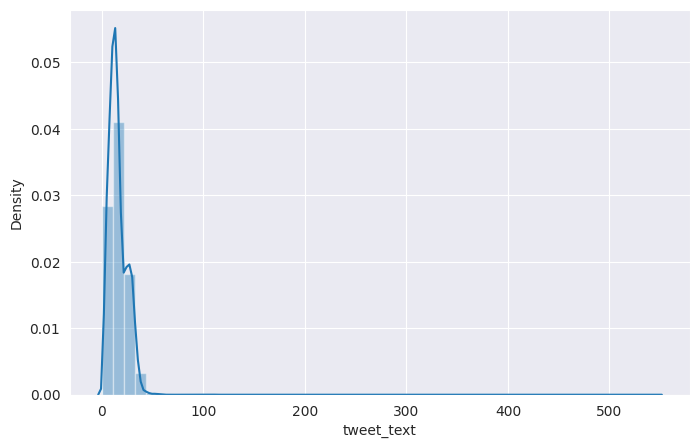

In [46]:
seqlen = x_train["tweet_text"].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(seqlen)

From the plot above, we can see that most of the text in x_train contains less that 100 words.

### Text Cleaning

In this section, we will:
- Clean the text by inserting spaces around each punctuation symbol in the puncts list.
- Clean numbers in the text by replacing repeating digits with hashtags of varying lengths.
- Apply lowercase, clean_text, and clean_numbers to a given text.
- Fills missing values in the "text" column with "##".
These processes will be applied on x_train and x_valid only.

In [47]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x


    text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text

In [48]:
def preprocess(df, text_col_name):

    # lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df

In [49]:
x_train = preprocess(x_train.copy(), "tweet_text")
x_valid = preprocess(x_valid.copy(), "tweet_text")

print(x_train.head())

                                              tweet_text
12276  marleygotboobs gay r not sissi st men r we run...
17518  newsflash evilanglist not christian he deplora...
4127   ncweaver i ran difficulty getting respond whic...
19027  it not satire free speech pretending solve not...
23449  you know historically burned book nazi radical...


### WordCloud

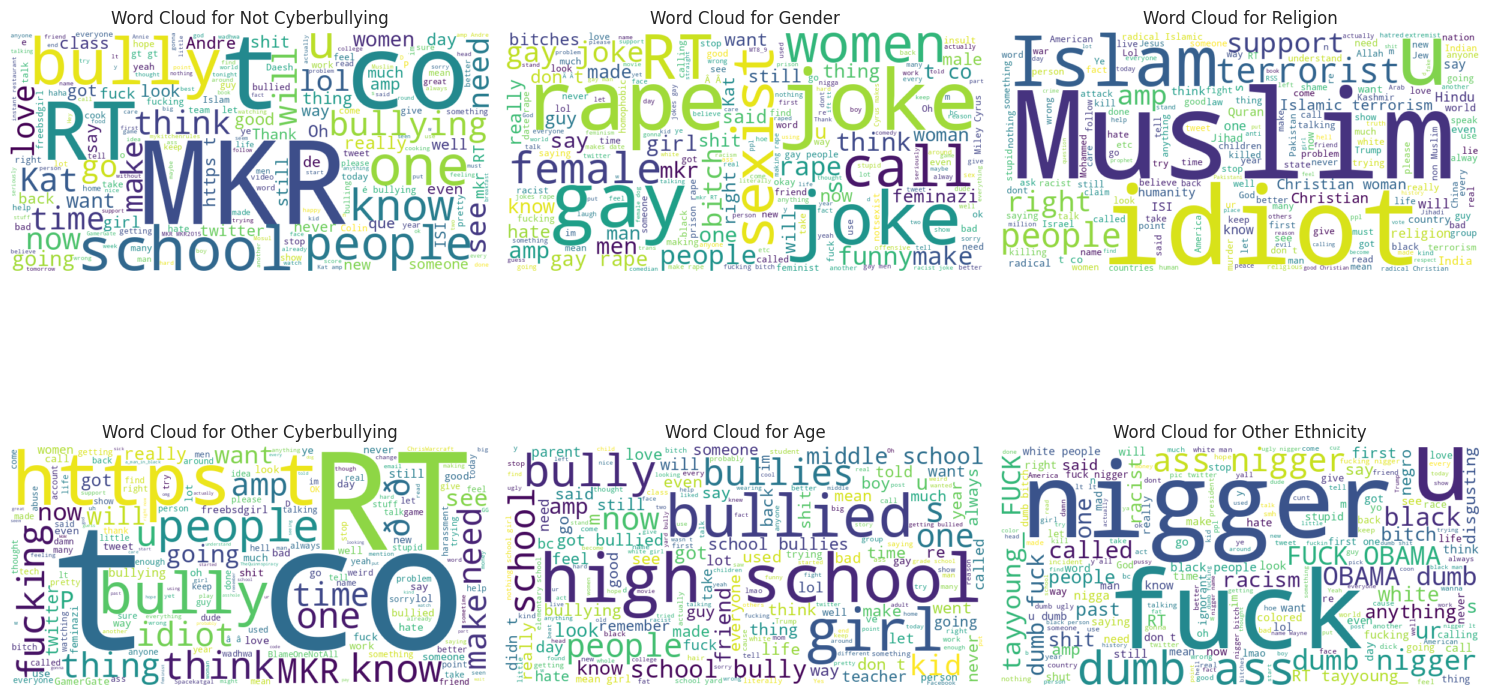

In [50]:
from wordcloud import WordCloud

# Find unique cyberbullying types
unique_types = df['cyberbullying_type'].unique()

# Set up the plot with subplots
fig, axs = plt.subplots(nrows=len(unique_types)//3, ncols=3, figsize=(15, 10))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array for easy iteration

# Loop through each type and create a word cloud
for i, bully_type in enumerate(unique_types):
    # Filter tweets by type
    filtered_tweets = df[df['cyberbullying_type'] == bully_type]['tweet_text']

    # Join all the texts into a single string
    text = " ".join(tweet for tweet in filtered_tweets)

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    if(bully_type==0):
      axs[i].set_title('Word Cloud for Not Cyberbullying')
    if(bully_type==1):
      axs[i].set_title('Word Cloud for Gender')
    if(bully_type==2):
      axs[i].set_title('Word Cloud for Religion')
    if(bully_type==3):
      axs[i].set_title('Word Cloud for Other Cyberbullying')
    if(bully_type==4):
      axs[i].set_title('Word Cloud for Age')
    if(bully_type==5):
      axs[i].set_title('Word Cloud for Other Ethnicity')
# Adjust layout
plt.tight_layout()
plt.show()


Export cleaned data

In [53]:
x_train_df = pd.DataFrame(x_train)
x_train_df['Index'] = x_train.index
x_test_df = pd.DataFrame(x_test)
x_test_df['Index'] = x_test_df.index
x_val_df = pd.DataFrame(x_valid)
x_val_df['Index'] = x_val_df.index

combined_df = pd.concat([x_train_df[['Index', 'tweet_text']], x_test_df[['Index', 'tweet_text']], x_val_df[['Index', 'tweet_text']]], ignore_index=True)
combined_df['tweet_text'] = combined_df['tweet_text'].apply(lambda x: ''.join(x))
combined_df = combined_df.sort_values(by='Index')
combined_df = combined_df.reset_index(drop=True)

df['Clean_Text'] = combined_df['tweet_text']
df.to_csv('clean cyberbullying tweets.csv')

### Tokenization

**Tokenization** is the process of breaking down a sequence of text into smaller units, known as tokens. In the context of NLP, these tokens are typically words, subwords, or even characters. The goal of tokenization is to convert a continuous text into discrete units that can be easily processed by algorithms, such as Ernie.

Here we initialized the sequence length to 80 and use the AutoTokenizer, which is an efficient tokenizer provided by the Hugging Face Transformers library for Ernie models. We will also apply tokenization to x_train and x_valid only. The resulting tokenized input consists of 'input_ids' and attention_masks.

In [ ]:
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten, InputLayer, Bidirectional, GlobalAveragePooling1D
from keras.models import Model, load_model
from transformers import AutoTokenizer, TFBertModel
MODEL_NAME = "nghuyong/ernie-2.0-base-en"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize(df):
    input_ids =  []
    attention_masks =  []

    for i, text in enumerate(df["tweet_text"]):
        tokens = tokenizer.encode_plus(text, max_length=80,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')

        input_ids.append(np.asarray(tokens["input_ids"]).reshape(80,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(80,))

    return (np.asarray(input_ids), np.asarray(attention_masks))

train_input_ids, train_attention_masks = tokenize(x_train)
valid_input_ids, valid_attention_masks = tokenize(x_valid)

print(train_input_ids[0])

[  101 20326  3995  2102  5092 16429  2015  5637  1054  2025 24761  5332
  2358  2273  1054  2057  2448  3827  9040  2009  2204  2154  8257   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


### One Hot Encoding

The one_encode_labels function is designed for one-hot encoding labels in a multi-class classification scenario. The one-hot encoding is only applied to y_train and y_valid.








In [ ]:
def one_encode_labels(df):
    emotion_values = set(df["cyberbullying_type"].values)
    labels = []
    for index, row in df.iterrows():
        label = np.zeros((len(emotion_values)))
        label[row["cyberbullying_type"]] = 1
        labels.append(label)
    labels = np.asarray(labels)
    return labels

In [ ]:
y_train = one_encode_labels(y_train)
y_valid = one_encode_labels(y_valid)

print(y_train[1])

[0. 0. 1. 0. 0. 0.]


## Ernie Model

For the model, we use TFBertModel.from_pretrained('ernie-2.0'), a TensorFlow Keras model for the Ernie architecture, loading pre-trained weights from the 'nghuyong/ernie-2.0-base-en' checkpoint.

In [ ]:
ernie = TFBertModel.from_pretrained(MODEL_NAME, from_pt=True)

You are using a model of type ernie to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['ernie.encoder.layer.5.attention.self.query.weight', 'ernie.encoder.layer.11.attention.output.LayerNorm.bias', 'ernie.encoder.layer.3.attention.self.query.weight', 'ernie.encoder.layer.11.output.dense.bias', 'ernie.encoder.layer.9.attention.self.query.bias', 'ernie.encoder.layer.5.attention.self.query.bias', 'ernie.encoder.layer.10.intermediate.dense.weight', 'ernie.encoder.layer.6.intermediate.dense.weight', 'ernie.encoder.layer.1.attention.output.dense.bias', 'ernie.encoder.layer.1.attention.output.LayerNorm.bias', 'ernie.encoder.layer.4.intermediate.dense.bias', 'ernie.encoder.layer.11.attention.output.LayerNorm.weight', 'ernie.encoder.layer.5.attention.output.LayerNorm.bias', 'ernie.encoder.layer.4.attention.output.dense.bias', 'ernie.encoder.layer.1.attention.self.value.bias', 'ernie.encoder.layer.0.output.LayerNorm.bias', 'ernie.encoder.layer.9.output.LayerNorm.weight', 'ernie.encoder

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

### Ernie

In [ ]:
def create_model(models, max_len):

    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Ambil output dari model pre-trained
    output_models = models([input_ids, attention_mask])

    # Asumsi output_models[1] memiliki dimensi (batch_size, timesteps, features)
    if len(output_models[1].shape) == 2:
        # Jika output adalah 2D, tambahkan dimensi ekstra
        output = tf.expand_dims(output_models[1], axis=1)
    else:
        output = output_models[1]

    # Lanjutkan dengan lapisan pooling dan lainnya
    output = GlobalAveragePooling1D()(output)
    output = BatchNormalization()(output)
    output = Dense(32, activation="relu")(output)
    output = Dropout(0.3)(output)
    output = Dense(6, activation='softmax')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

ernie_model = create_model(ernie, 80)
ernie_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 80)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 80)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094837   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   76         'attention_mask[0][0]']      
                             hidden_state=(None, 80, 76                                       

### Callbacks

To prevent overfitting, we use 'early_stopping' and 'reduce_lr'. 'early_stopping' stops the training when the val_loss doesn't improve for 5 consecutive epochs. 'reduce_lr' reduces the learning rate if val_loss doesn't improve for 3 consecutive epochs, with a minimum learning rate of 1e-07. 'model_checkpoint' saves the weight of the model when the val_acc exceeds the previous best one.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/UAS DL/Ernie.h5', monitor='val_acc', save_best_only=True, verbose=1)

### Function to calculate F1 Score

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    """
    F1 score metric based on Keras Precision and Recall metrics.
    """
    def __init__(self, name = "f1_score", **kwargs):
        super(F1Score, self).__init__(name = name, **kwargs)

        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight = None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def result(self):
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result()))
class F1Score_loss(tf.keras.metrics.Metric):
    """
     F1 score metric based on Keras Precision and Recall metrics.
    """
    def __init__(self, name = "f1_score", **kwargs):
        super(F1Score_loss, self).__init__(name = name, **kwargs)

        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight = None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def result(self):
        return 1-(2 / ((1 / self.precision.result()) + (1 / self.recall.result())))

### Compiling the Model

We use Adam optimizer with learning rate of 1e-05. Then we use several metrics to calculate the accuracy, precision, recall, F1 score, and F1 Score loss. Because there are several classes in label, we use CategoricalCrossEntropy as the loss.

In [ ]:
optimizer = Adam(1e-04)

# Assuming 'accuracy', 'f1', and 'recall' are your metric names
metrics = [
    CategoricalAccuracy(name='acc'),
    Precision(name='precision'),
    Recall(name='recall'),
    F1Score(name='f1'),
    F1Score_loss(name='f1_loss')
]
loss = tf.keras.losses.CategoricalCrossentropy()
ernie_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Then, we train the data with train_input_ids, train_attention_masks, and y_train. We also use the valid_input_ids, valid_attention_masks, and y_valid to validate the training. We fit the model for epoch = 25, batch size = 128, and incorporate the callbacks earlier.

In [ ]:
history = ernie_model.fit((train_input_ids, train_attention_masks),y_train,
                    validation_data=((valid_input_ids,valid_attention_masks),y_valid),
                    epochs=25, batch_size=128,
                    callbacks = [model_checkpoint, reduce_lr, early_stopping])

Epoch 1/25
261/261 [==============================] - ETA: 0s - loss: 0.6779 - acc: 0.7288 - precision: 0.8250 - recall: 0.6373 - f1: 0.7191 - f1_loss: 0.2809
Epoch 1: val_acc improved from -inf to 0.81381, saving model to /content/drive/MyDrive/UAS DL/Ernie.h5
261/261 [==============================] - 346s 1s/step - loss: 0.6779 - acc: 0.7288 - precision: 0.8250 - recall: 0.6373 - f1: 0.7191 - f1_loss: 0.2809 - val_loss: 0.4585 - val_acc: 0.8138 - val_precision: 0.8445 - val_recall: 0.7835 - val_f1: 0.8128 - val_f1_loss: 0.1872 - lr: 1.0000e-04
Epoch 2/25
261/261 [==============================] - ETA: 0s - loss: 0.4434 - acc: 0.8173 - precision: 0.8638 - recall: 0.7602 - f1: 0.8087 - f1_loss: 0.1913
Epoch 2: val_acc did not improve from 0.81381
261/261 [==============================] - 280s 1s/step - loss: 0.4434 - acc: 0.8173 - precision: 0.8638 - recall: 0.7602 - f1: 0.8087 - f1_loss: 0.1913 - val_loss: 0.6306 - val_acc: 0.7745 - val_precision: 0.8243 - val_recall: 0.7248 - val_f

The training stopped at epoch 11 because the val_acc doesn't improve for 5 consecutive epochs. The best val_acc was 82.877% with precision 83.59%, val_recall = 82.05%, val_f1 = 82.82%, and val_loss = 0.4894.

## Evaluate the Model

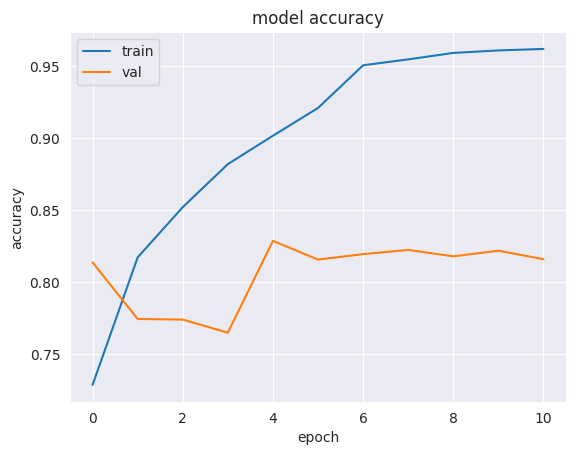

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the plot, we can see that the model is a experiencing overfitting, because the validation accuracy was stuck at 80's%, while the training accuracy is gradually climbing.

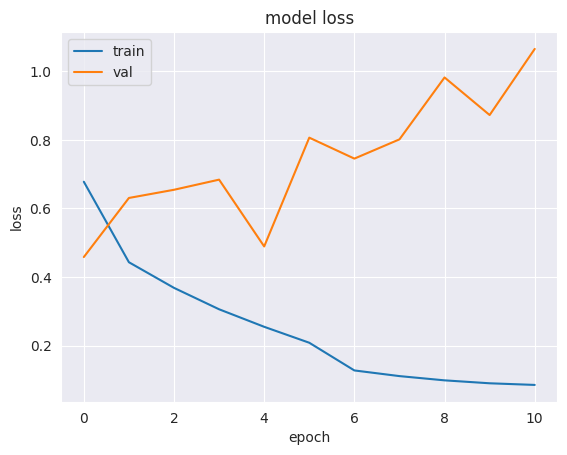

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the plot, we can see that the model is a experiencing overfitting, because the validation loss is increasing over time while the training loss is decreasing.

## Ernie Model Prediction on Test Data

Firstly, we have to tokenize the x_test

In [ ]:
test_input_ids, test_attention_masks = tokenize(x_test)

Then we predict the x_test

In [ ]:
result = ernie_model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

224/224 [==============================] - 20s 77ms/step


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# predictions need to go through same preprocessings
def prep_data(text):
    text = preprocess_text(text)

    tokens = tokenizer.encode_plus(text, max_length=80,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')

    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

def predict(text):
    in_tensor = prep_data(text)
    probs = ernie_model.predict(in_tensor)[0]
    return (np.argmax(probs))

In [ ]:
predictions = np.asarray(x_test["tweet_text"].apply(lambda x: predict(x)))
test_vals = np.asarray(y_test["cyberbullying_type"])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step


After converting the predictions into an array, we build the confusion matrix and classification report

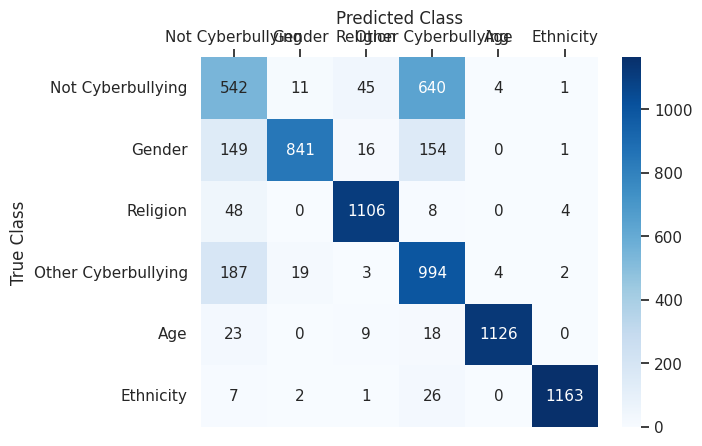

                     precision    recall  f1-score   support

  Not Cyberbullying     0.5669    0.4360    0.4930      1243
             Gender     0.9633    0.7244    0.8269      1161
           Religion     0.9373    0.9485    0.9429      1166
Other Cyberbullying     0.5402    0.8222    0.6520      1209
                Age     0.9929    0.9575    0.9749      1176
          Ethnicity     0.9932    0.9700    0.9814      1199

           accuracy                         0.8068      7154
          macro avg     0.8323    0.8098    0.8119      7154
       weighted avg     0.8286    0.8068    0.8085      7154



In [ ]:
confusion = confusion_matrix(test_vals, predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["Not Cyberbullying", "Gender", "Religion", "Other Cyberbullying", "Age", "Ethnicity"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0,
                 cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(test_vals, predictions, digits = 4, output_dict=False,
                               target_names=["Not Cyberbullying", "Gender", "Religion", "Other Cyberbullying", "Age", "Ethnicity"],)
print(report)

From the confusion matrix, we can see that the model yields 80.68% accuracy on the test set. There are some things that we should note:

- The model seems to find it difficult to differentiate which texts are categorized as not cyberbullying and which are categorized as other cyberbullying. It can be seen from the classification_report that 'not_cyberbullying' has a recall of 43.6%. Meaning, the model correctly identifies only 43.6% of all 'not_cyberbullying' texts.
- The 'other_cyberbullying' label has a precision of 54.02%, meaning when predicting whether a text belongs to 'other_cyberbullying' label, it's correct 54.02% of the time.
- The other labels has already reached a fine result with F1 score of 82.69%-98.14%.

In conclusion, to build a better model, we can implement or adjust regularization techniques like L1 or L2 regularization to prevent overfitting, especially if the model performs well on the training set but poorly on the test set. We can also combine the predictions of several models to improve accuracy. Techniques like stacking, blending, or a simple majority vote among diverse models can help improve performance, especially in boundary cases between classes.

In [27]:
x_train_df

,tweet_text,Index
12276,marleygotboobs gay r not sissi st men r we run...,12276
17518,newsflash evilanglist not christian he deplora...,17518
4127,ncweaver i ran difficulty getting respond whic...,4127
19027,it not satire free speech pretending solve not...,19027
23449,you know historically burned book nazi radical...,23449
...,...,...
11284,female like roseanne barr hideous bitch i call...,11284
44732,it question dumb telly tubby is ya clit fat pu...,44732
38158,one kid turned leftist just like bully friend ...,38158
860,rt ravenhuwolf university texas arlington musl...,860
